# Przygotowanie

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Lecimy v2

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import cv2
import os

In [0]:
# Dwie klasy lepsze od 1!
NUM_CLASSES = 2

# 3 kanały koloru
CHANNELS = 3

# Wielkość ResNetu
IMAGE_RESIZE = 224
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'
LOSS_METRICS = ['accuracy']

NUM_EPOCHS = 100
EARLY_STOP_PATIENCE = 10

STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

BATCH_SIZE_TRAINING = 10
BATCH_SIZE_VALIDATION = 10

BATCH_SIZE_TESTING = 1

In [0]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2

from keras.applications.resnet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras import optimizers

In [0]:
all_results = {}

# Data
image_size = IMAGE_RESIZE
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
path = '/content/drive/My Drive/Data'
slash = '/'
train_generator = data_generator.flow_from_directory(
        directory=path + slash + 'test' + slash,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')
validation_generator = data_generator.flow_from_directory(
        directory=path + slash + 'valid'+ slash,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical')
  
# Callbacks
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = path + slash + 'saved_models' + slash + 'best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

test_generator = data_generator.flow_from_directory(
    directory = path + slash + 'show' + slash,
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

TEST_DIR = path + slash + 'show' + slash

Found 6168 images belonging to 2 classes.
Found 9580 images belonging to 2 classes.
Found 25 images belonging to 2 classes.


In [0]:
def do_the_job(resnet, name):

  print(f'{name}\n')


  # Model
  model = Sequential()
  model.add(resnet)
  model.add(Dense(512, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))
  model.layers[0].trainable = False

  model.summary()

  # Optimizers
  model.compile(optimizer = 'adadelta', loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

  # Fit
  fit_history = model.fit_generator(
          train_generator,
          steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
          epochs = NUM_EPOCHS,
          validation_data=validation_generator,
          validation_steps=STEPS_PER_EPOCH_VALIDATION,
          callbacks=[cb_checkpointer, cb_early_stopper]
  )
  model.load_weights(path + slash + 'saved_models' + slash + 'best.hdf5')
  
  # Save
  model.save(path + slash + 'saved_models' + slash + name + '.h5')

  # Score
  scoreRes = model.evaluate_generator(
        generator=validation_generator
  )
  all_results[name] = scoreRes

  # Raport
  plt.figure(1, figsize = (15,8)) 
    
  plt.subplot(221)  
  plt.plot(fit_history.history['acc'])  
  plt.plot(fit_history.history['val_acc'])  
  plt.title('model accuracy')  
  plt.ylabel('accuracy')  
  plt.xlabel('epoch')  
  plt.legend(['train', 'valid']) 
      
  plt.subplot(222)  
  plt.plot(fit_history.history['loss'])  
  plt.plot(fit_history.history['val_loss'])  
  plt.title('model loss')  
  plt.ylabel('loss')  
  plt.xlabel('epoch')  
  plt.legend(['train', 'valid']) 

  plt.show()

  test_generator.reset()
  pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)
  predicted_class_indices = np.argmax(pred, axis = 1)

  print(f'class indices: {test_generator.class_indices}')

  f, ax = plt.subplots(5, 5, figsize = (15, 15))

  for i in range(0,25):
      imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
      imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
      
      predicted_class = str(predicted_class_indices[i])

      ax[i//5, i%5].imshow(imgRGB)
      ax[i//5, i%5].axis('off')
      ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    

  plt.show()
  del model
  print(f'------------------')













VanilaResNet50V2_avg

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_6 (Dense)     

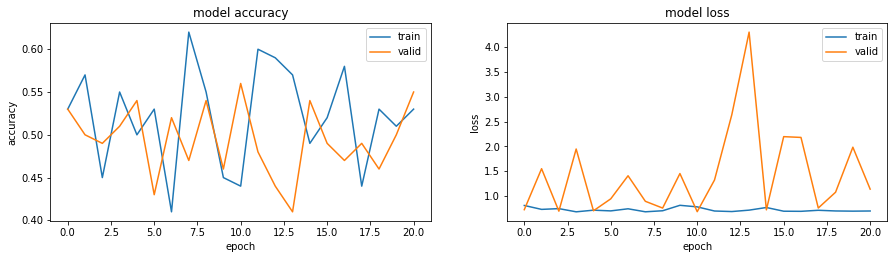

25/25 [==============================] - 9s 357ms/step
class indices: {'originals': 0, 'photoshops': 1}


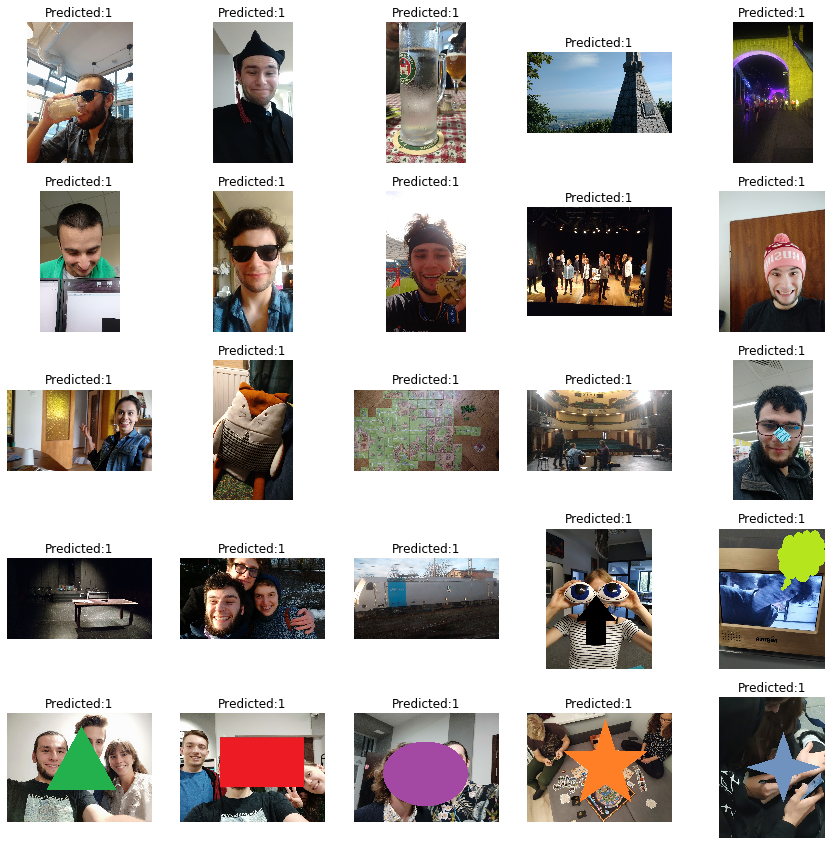

------------------


In [0]:
do_the_job(resnet=ResNet50V2(include_top = False, pooling = 'avg', weights = None), name='VanilaResNet50V2_avg')

VanilaResNet50V2_max

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_7 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_12 (Dense)             (No

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10/10 [==============================] - 51s 5s/step - loss: 5.8025 - acc: 0.6400 - val_loss: 8.3814 - val_acc: 0.4800
Epoch 18/100
10/10 [==============================] - 51s 5s/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.2202 - val_acc: 0.4900
Epoch 19/100
10/10 [==============================] - 50s 5s/step - loss: 7.4143 - acc: 0.5400 - val_loss: 7.0920 - val_acc: 0.5600
Epoch 20/100
10/10 [==============================] - 50s 5s/step - loss: 9.0261 - acc: 0.4400 - val_loss: 7.8979 - val_acc: 0.5100


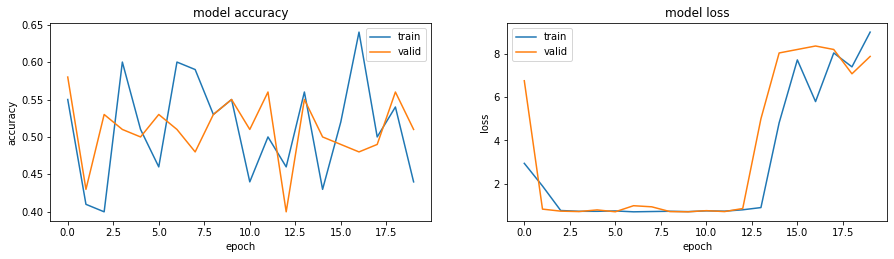

25/25 [==============================] - 9s 354ms/step
class indices: {'originals': 0, 'photoshops': 1}


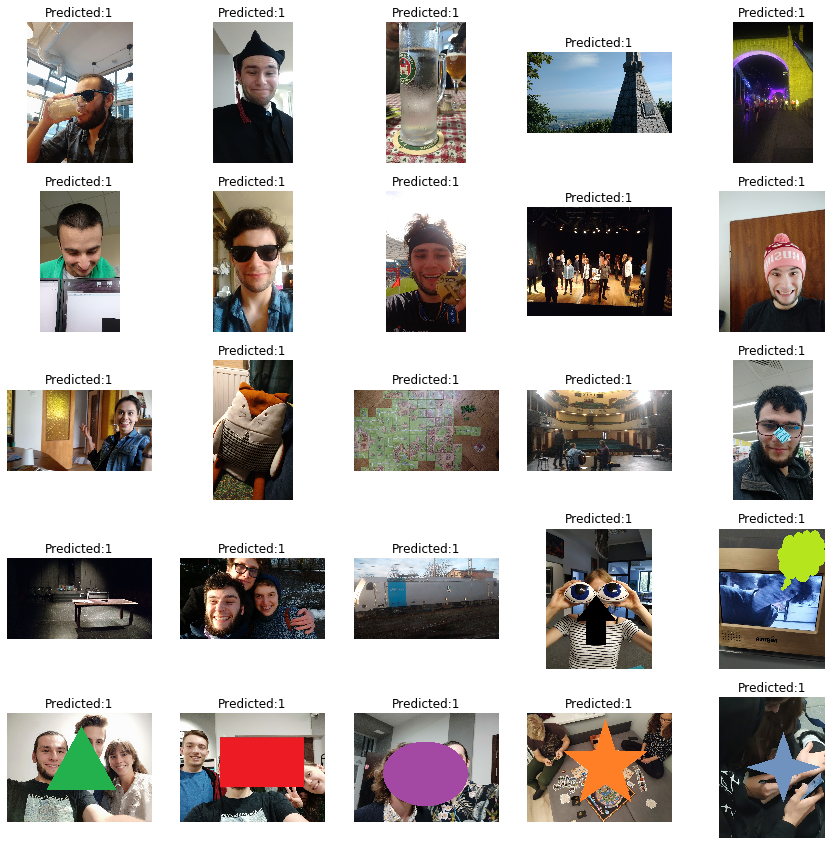

------------------


In [0]:
do_the_job(resnet=ResNet50V2(include_top = False, pooling = 'max', weights = None), name='VanilaResNet50V2_max')













VanilaResNet101V2_avg

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Model)          (None, 2048)              42626560  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_6 (Dense)    

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 197 could not be retrieved. It could be because a worker has died.
  UserWarning)


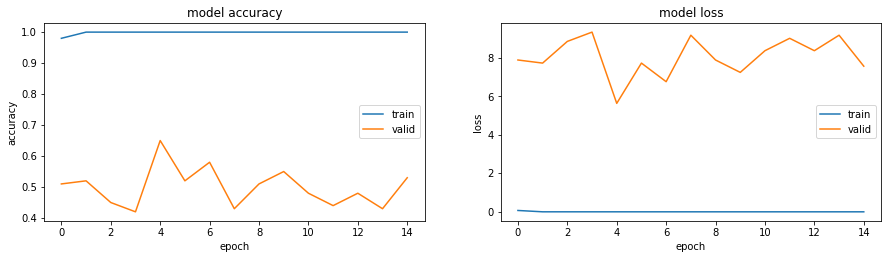

25/25 [==============================] - 18s 701ms/step
class indices: {'originals': 0, 'photoshops': 1}


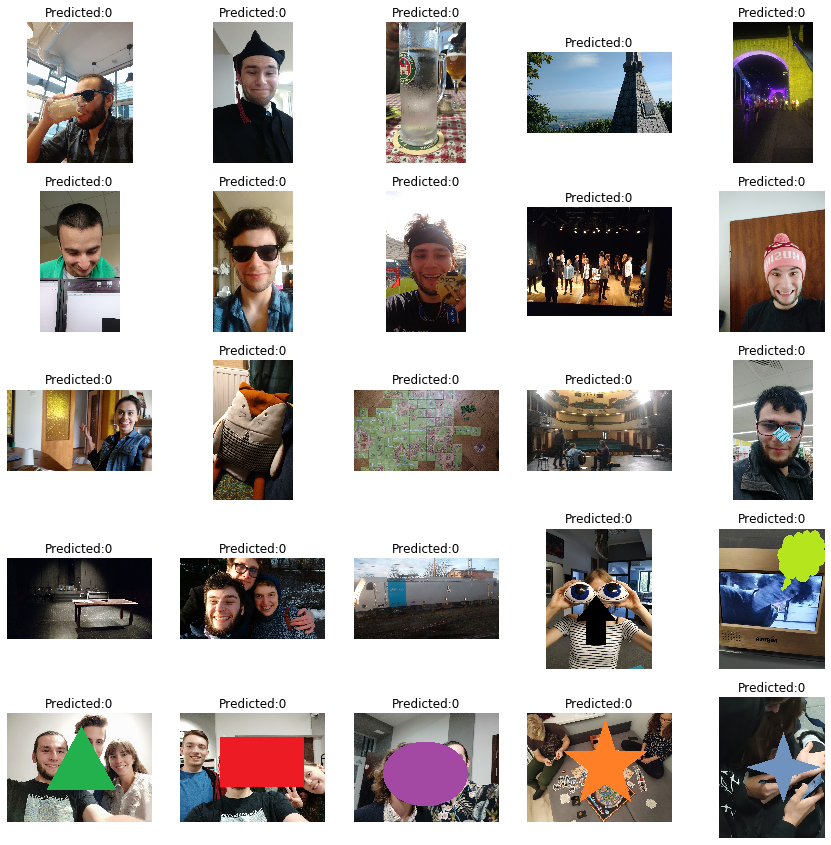

------------------


In [0]:
do_the_job(resnet=ResNet101V2(include_top = False, pooling = 'avg', weights = None), name='VanilaResNet101V2_avg')

VanilaResNet101V2_max

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Model)          (None, 2048)              42626560  
_________________________________________________________________
dense_7 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_12 (Dense)             (N

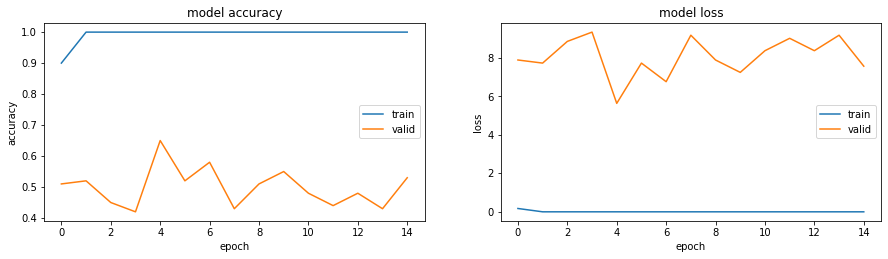

25/25 [==============================] - 15s 595ms/step
class indices: {'originals': 0, 'photoshops': 1}


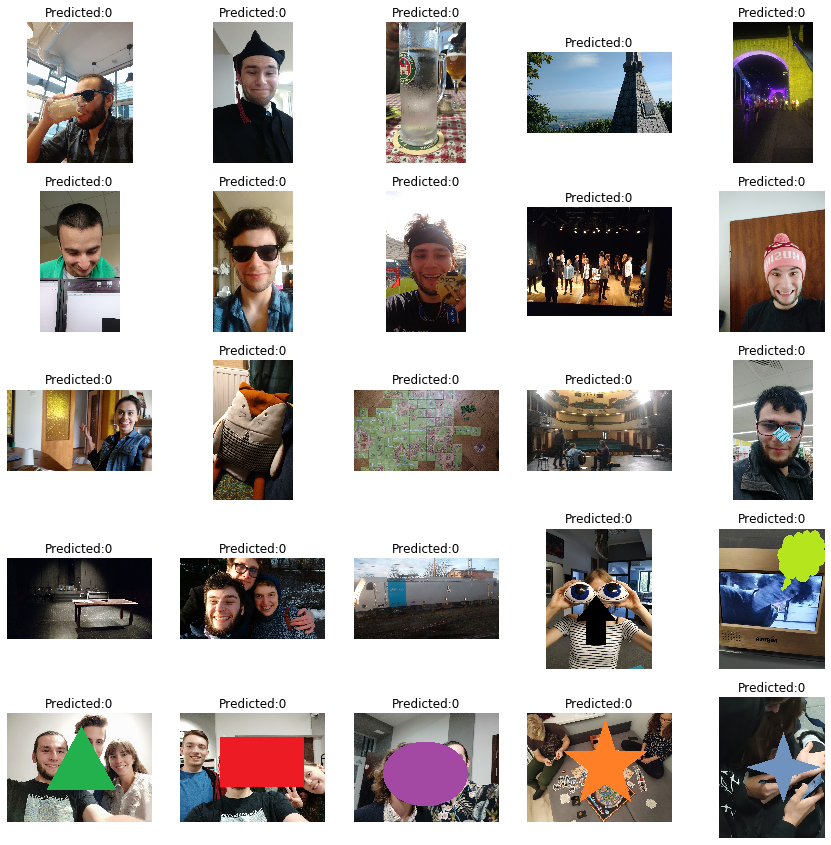

------------------


In [0]:
do_the_job(resnet=ResNet101V2(include_top = False, pooling = 'max', weights = None), name='VanilaResNet101V2_max')

In [0]:
do_the_job(resnet=ResNet152V2(include_top = False, pooling = 'avg', weights = None), name='VanilaResNet152V2_avg')

VanilaResNet152V2_avg

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 2048)              58331648  
_________________________________________________________________
dense_31 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_32 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_33 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_34 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_35 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_36 (Dense)             (N

OSError: ignored

In [0]:
do_the_job(resnet=ResNet152V2(include_top = False, pooling = 'max', weights = None), name='VanilaResNet152V2_max')

In [0]:
all_results